In [1]:
from typing import List,Tuple
from random import choices
from functools import partial
import sys
sys.path.append('/kaggle/input/gt-proj')

# from F import Genome, stock_data, Population, FitnessFunc, populate, generate_fuzzy, run_evolution, fitness, mutation

# from FuzzyLogic import Genome,stock_data,Population,FitnessFunc,populate,generate_fuzzy,run_evolution,fitness,mutation
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plotter

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Load and clean data
data = pd.read_csv('/kaggle/input/gt-proj/Data.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data_clean = data.drop(columns=['Volume'])

# Create a target column: 1 if price went up, 0 if price went down
data_clean['Target'] = (data_clean['Close'].shift(-1) > data_clean['Close']).astype(int)
data_clean = data_clean.dropna()

# Prepare the features (X) and target (y)
X = data_clean[['Open', 'High', 'Low', 'Close']].values
y = data_clean['Target'].values

# Split the data into train, validation, and test sets (60% train, 20% valid, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the features (based on the training set)
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
X_train_normalized = (X_train - X_train_mean) / X_train_std
X_valid_normalized = (X_valid - X_train_mean) / X_train_std
X_test_normalized = (X_test - X_train_mean) / X_train_std

# Create the neural network
def create_agent(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification: buy (1) or sell (0)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train a neural network for each player
def train_agents(num_players, X_train_normalized, y_train, X_valid_normalized, y_valid, input_dim):
    agents = []
    for player in range(num_players):
        agent = create_agent(input_dim)
        agent.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_data=(X_valid_normalized, y_valid), verbose=0)
        agents.append(agent)
        print(f"Player {player + 1} neural network trained.")
    return agents

# Simulate trading based on each player's neural network predictions
def simulate_trading_multi(agents, X_test, y_test, num_players=3):
    initial_investments = [1000 for _ in range(num_players)]  # Different initial investments for each player
    portfolio_values = [[initial] for initial in initial_investments]  # List to track portfolio values for each player
    investments = initial_investments[:]  # Copy initial investments for each player

    # Go through the test set and simulate buy/sell actions for each player
    for i in range(len(X_test) - 1):
        for player in range(num_players):
            agent = agents[player]  # Use the corresponding agent for each player
            prediction = agent.predict(X_test_normalized[i:i+1])[0][0]  # Predict using the player's network

            if prediction >= 0.5:  # Model predicts 'buy'
                # If the stock goes up, increase the portfolio value
                if y_test[i] == 1:
                    investments[player] += investments[player] * ((X_test[i+1][3] - X_test[i][3]) / X_test[i][3])  # (Close price percentage change)
            else:  # Model predicts 'sell'
                # If the stock goes down, reduce the portfolio value
                if y_test[i] == 0:
                    investments[player] -= investments[player] * ((X_test[i][3] - X_test[i+1][3]) / X_test[i][3])  # (Close price percentage change)

            # Track the updated investment for each player
            portfolio_values[player].append(investments[player])

#     # Debugging: print portfolio values for each player
#     for player in range(num_players):
#         print(f"Player {player + 1} (Initial Investment = {initial_investments[player]:.2f}) Portfolio Values: {portfolio_values[player]}")

    return portfolio_values

# Build the agents for 3 players
num_players = 3
input_dim = X_train.shape[1]



In [3]:
from IPython.display import clear_output

In [4]:
# Run the simulation for 3 players
agents = train_agents(num_players, X_train_normalized, y_train, X_valid_normalized, y_valid, input_dim)
portfolio_values = simulate_trading_multi(agents, X_test, y_test, num_players=num_players)
clear_output()

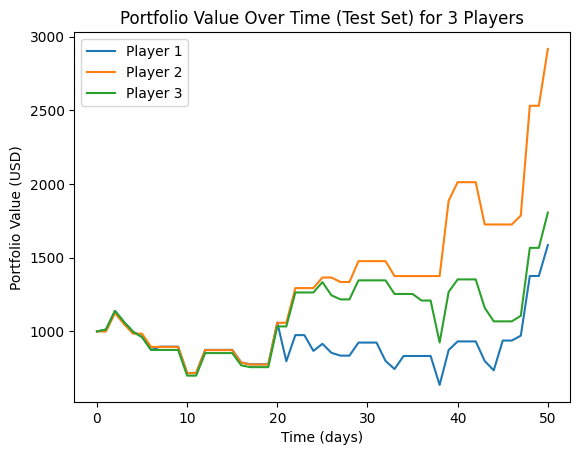

In [5]:

# Plot the portfolio values for each player over time
for player in range(num_players):
    plt.plot(portfolio_values[player], label=f'Player {player + 1}')

plt.title('Portfolio Value Over Time (Test Set) for 3 Players')
plt.ylabel('Portfolio Value (USD)')
plt.xlabel('Time (days)')
plt.legend()
plt.savefig('portfolio_values_plot.png')
plt.show()